感知机
===

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

# 1.数据分析

In [2]:
data = np.genfromtxt('data/perceptron_toydata.txt', delimiter='\t')
X, y = data[:, :2], data[:, 2]
y = y.astype(np.int)

print('Class label counts:', np.bincount(y))
print('X.shape:', X.shape)
print('y.shape:', y.shape)

# Shuffling & train/test split
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X, y = X[shuffle_idx], y[shuffle_idx]

X_train, X_test = X[shuffle_idx[:70]], X[shuffle_idx[70:]]
y_train, y_test = y[shuffle_idx[:70]], y[shuffle_idx[70:]]

# Normalize (mean zero, unit variance)
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

Class label counts: [50 50]
X.shape: (100, 2)
y.shape: (100,)


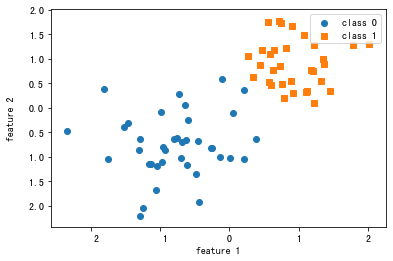

In [3]:
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()

# 2.定义感知机模型

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def custom_where(cond, x_1, x_2):
    return (cond * x_1) + ((~cond) * x_2)

class Perceptron():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, 
                                   dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)

    def forward(self, x):
        linear = torch.add(torch.mm(x, self.weights), self.bias)
        predictions = custom_where(linear > 0., 1, 0).float()
        return predictions
        
    def backward(self, x, y):  
        predictions = self.forward(x)
        errors = y - predictions
        return errors
        
    def train(self, x, y, epochs):
        for e in range(epochs):
            for i in range(y.size()[0]):
                # use view because backward expects a matrix (i.e., 2D tensor)
                errors = self.backward(x[i].view(1, self.num_features), y[i]).view(-1)
                self.weights += (errors * x[i]).view(self.num_features, 1)
                self.bias += errors
                
    def evaluate(self, x, y):
        predictions = self.forward(x).view(-1)
        accuracy = torch.sum(predictions == y).float() / y.size()[0]
        return accuracy

# 3.训练模型

In [7]:
ppn = Perceptron(num_features=2)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

ppn.train(X_train_tensor, y_train_tensor, epochs=5)

print('Model parameters:')
print('  Weights: %s' % ppn.weights)
print('  Bias: %s' % ppn.bias)

Model parameters:
  Weights: tensor([[1.2734],
        [1.3464]])
  Bias: tensor([-1.])


# 4.预测模型

In [8]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

test_acc = ppn.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 93.33%


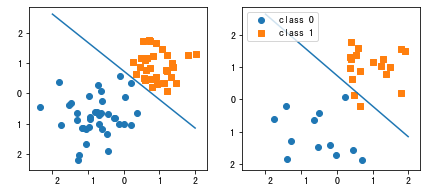

In [9]:
w, b = ppn.weights, ppn.bias

x_min = -2
y_min = ( (-(w[0] * x_min) - b[0]) / w[1] )

x_max = 2
y_max = ( (-(w[0] * x_max) - b[0]) / w[1] )

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')